# Gillespie Algorithm for PUK 2024

___

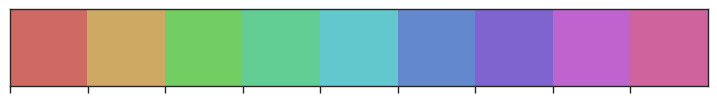

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as sc
import numba
from scipy import signal
from tqdm import tqdm


sns.set()
sns.set_context("paper", font_scale=1.4)
sns.set_style("ticks")

colors = sns.color_palette('hls', 10, desat = 0.8)
#colors = colors[::-1]
colors.pop(2)

sns.set_palette(colors)
sns.palplot(colors)

plt.rcParams['axes.grid'] = True
plt.rcParams['axes.grid.axis'] = 'y'
plt.rcParams['axes.grid.which'] = 'major'
plt.rcParams['grid.linestyle'] = '--'
plt.rcParams['grid.linewidth'] = 1.5
plt.rcParams['figure.figsize'] = (16, 9)
plt.rcParams['figure.dpi'] = 150

rc = {"font.family" : "serif", 
      "mathtext.fontset" : "stix"}
plt.rcParams.update(rc)
plt.rcParams["font.serif"] = ["Times New Roman"] + plt.rcParams["font.serif"]


In [2]:
# Brusselator equations 

@numba.njit
def x_dot_init(x, y, V, params):
    dxdt = params[0]*V - (params[1] + params[3]) * x + params[2]/(V**2) * x**2 * y
    return dxdt

@numba.njit
def y_dot_init(x, y, V, params):
    dydt = params[1]*x - params[2]/(V**2) * x**2 * y
    return dydt
    

# Fixed Point eqations 

@numba.njit
def x_mark(V, params):
    return params[0]*V / params[3]

@numba.njit
def y_mark(V, params):
    return V * params[1] * params[3] / (params[2] * params[0])


In [3]:
# Defining gillespie function

@numba.njit(fastmath=True)
def gillespie(x, y, t_max, b_place=5.5, V=100):

    t = 0
    click = 1
    t_list = [0]
    x_list = [x]
    y_list = [y]

    a = 2 * V
    c = 1/V**2
    d = 1
    
    
    while t < t_max:
        # rates
        x_spawn = a
        x_to_y = b_place * x
        y_to_x = c * x * (x-1) * y
        x_despawn = d * x
        
        rates = np.array([x_spawn, x_to_y, y_to_x, x_despawn])

        r_sum = np.cumsum(rates)
        R = np.sum(rates)
        u = np.random.uniform(0, R)
        dt = -np.log(np.random.uniform())/R


        mask = r_sum > u
        index = np.where(mask == True)[0][0]

        if index == 0:
            x += 1

        elif index == 1:
            x -= 1
            y += 1

        elif index == 2:
            y -= 1
            x += 1

        elif index == 3:
            x -= 1
        
        t += dt
        ts = 0.1
        if t > ts*click:
            t_list.append(t)
            x_list.append(x)
            y_list.append(y)
            click += 1

        #t_list.append(t)
        #x_list.append(x)
        #y_list.append(y)

    return np.array(t_list), np.array(x_list), np.array(y_list)



In [7]:
# Gillespie simulation initialization
vol = 100
x = 1000
y = 1000
t_max = 250

# Setting parameters
a = 2
b = 4.5
c = 1
d = 1

params = np.array([a, b, c, d])

# Running simulation
t_list, x_sim, y_sim = gillespie(x, y, t_max, b_place=b, V=vol)
x_star = x_mark(vol, params)
y_star = y_mark(vol, params)


# Turning to concentrations
x_sim = x_sim / vol
y_sim = y_sim / vol
x_star = x_star / vol
y_star = y_star / vol

[]


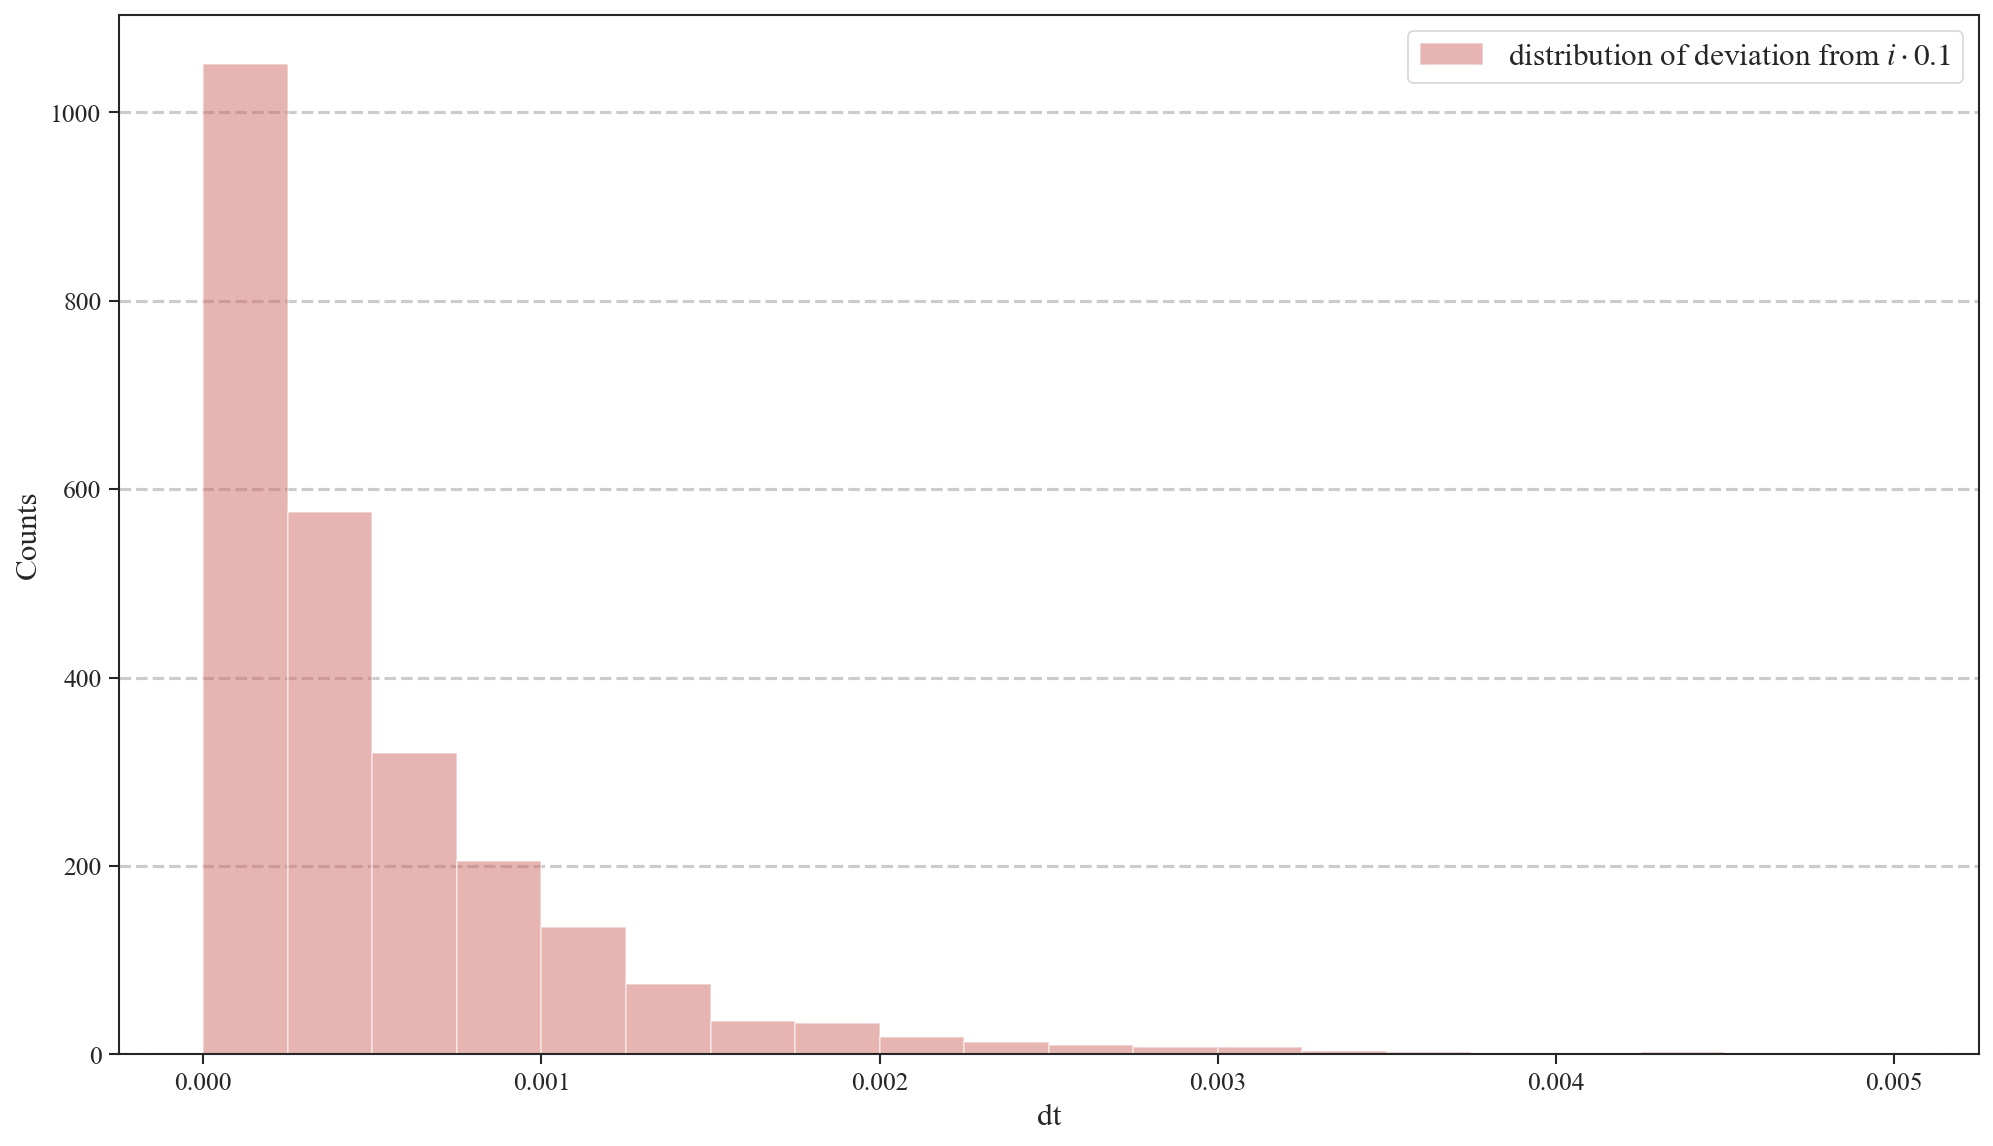

In [8]:
# Checking that the time steps are correct

n = np.arange(0, t_list[-1], 0.1)

dt_list = t_list - n
plt.hist(dt_list, bins=20, range=(0, 0.005), alpha=0.5, label=r'distribution of deviation from $i \cdot 0.1$');
plt.xlabel('dt', fontsize=15)
plt.ylabel('Counts', fontsize=15)
plt.legend(fontsize=15)

over = np.where(dt_list > 0.1)
print(over[0])

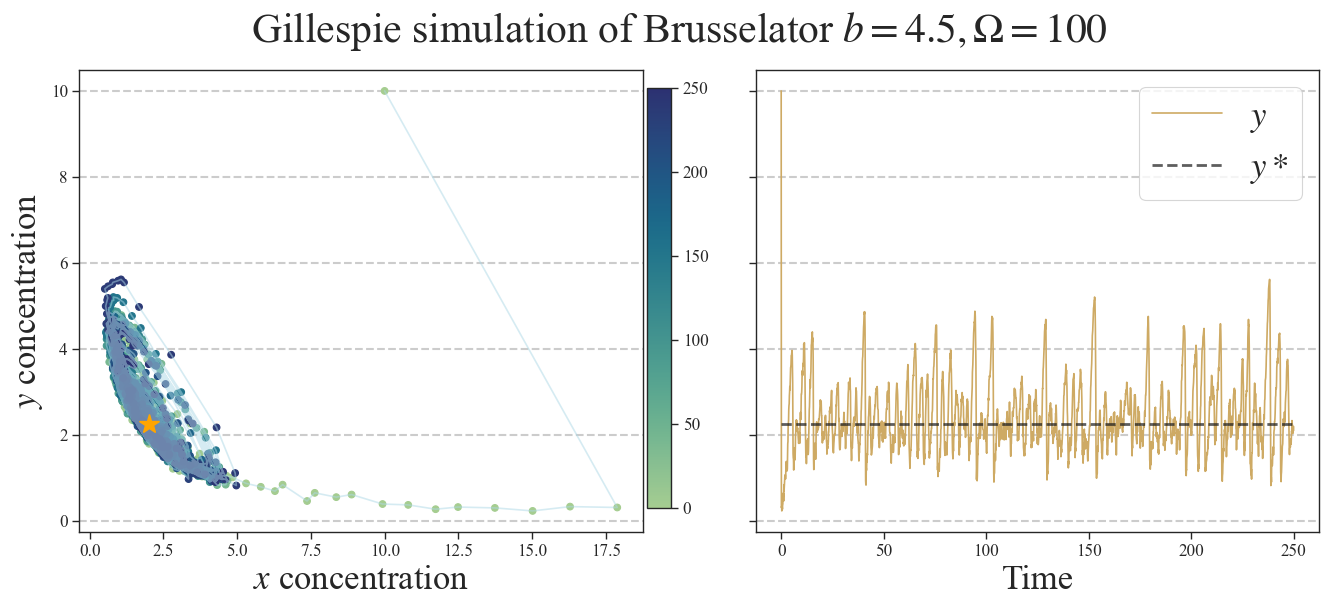

In [9]:
# Plotting gillespie simulation

fig, ax = plt.subplots(1,2, sharey=True, figsize=(16, 6), dpi=100)
ax[0].plot(x_sim, y_sim, color='lightblue', alpha=0.5, label='Trajectory')
im = ax[0].scatter(x_sim, y_sim, c=t_list, cmap='crest',  label=fr'$xy$-concentrations')

ax[0].plot(x_star, y_star, marker='*', ls='', markersize='15', color='orange', label='Fixed point')
cmax = fig.add_axes([0.48, 0.15, 0.015, 0.7])
fig.colorbar(im,cax=cmax, orientation='vertical')
ax[0].set_xlabel(r'$x$ concentration', fontsize=25)
ax[0].set_ylabel(r'$y$ concentration', fontsize=25)

# # Vector field
# field_size = np.arange(0, 6, 0.5)
# X, Y = np.meshgrid(field_size, field_size)
# U = x_dot_init(X, Y, vol, params)/vol
# P = y_dot_init(X, Y, vol, params)/vol
# ax[0].quiver(X, Y, U, P, angles='xy',  width=0.002, color='blue')
# ax[0].legend(fontsize=25, loc='upper right')


ax[1].plot(t_list, y_sim, label=r'$y$', color=colors[1])
ax[1].hlines(y_star, 0, t_max, color='k', alpha=0.7, linestyle='--', linewidth=2, label=r'$y*$')
ax[1].set_xlabel('Time', fontsize=25)

ax[1].legend(fontsize=25, loc='upper right')
plt.suptitle(r'Gillespie simulation of Brusselator $b=4.5, \Omega = 100$', fontsize=30)



plt.savefig('figurer/gillespie_simulation.png', dpi=150)

In [154]:
# Functions for amplitude finding and fourier transforming

@numba.njit(fastmath=True)
def peak_find(t_list, y_list, neigh=10):
    t_peak = []
    peaks = []
    for i in range(len(y_list) - neigh):
        if y_list[i] > y_list[i-1] and y_list[i] > y_list[i+1]:


            # check N neighbours each way
            index_check = []
            for j in range(1, neigh+1):
                if y_list[i] > y_list[i-j] and y_list[i] > y_list[i+j]:
                    index_check.append(True)
                else:
                    index_check.append(False)

            if sum(index_check) == neigh:
                peaks.append(y_list[i])
                t_peak.append(t_list[i])

    return np.array(t_peak), np.array(peaks),


@numba.njit(fastmath=True)
def valley_find(t_list, y_list, neigh=10):
    t_valley = []
    valleys = []
    for i in range(len(y_list) - neigh):
        if y_list[i] < y_list[i-1] and y_list[i] < y_list[i+1]:


            # check N neighbours each way
            index_check = []
            for j in range(1, neigh+1):
                if y_list[i] < y_list[i-j] and y_list[i] < y_list[i+j]:
                    index_check.append(True)
                else:
                    index_check.append(False)

            if sum(index_check) == neigh:
                valleys.append(y_list[i])
                t_valley.append(t_list[i])

    return np.array(t_valley), np.array(valleys)


@numba.njit(fastmath=True)
def amp_match(t_peak, y_peak, t_valley, y_valley):
    amp = []
    for i in range(len(t_peak) - 1):
        bigr = t_peak[i] < t_valley
        if sum(bigr) > 0:
            match = np.where(bigr == True)[0][0]
            amp.append((y_peak[i] - y_valley[match]))
        else:
            break
    return np.array(amp)


@numba.njit(fastmath=True)
def easy_fourier(t_list, y_list):
    array = np.array([0.1 * i for i in range(len(t_list))])
    dt_ty =  t_list - array
    sr = np.mean(dt_ty) + 0.1
    
    y_fft = np.fft.fft(y_list)
    amplitude_spectrum = np.abs(y_fft)
    frequencies = np.fft.fftfreq(len(y_fft), sr)
    freq_slice = frequencies[0:len(frequencies)//2]
    amp_slice = amplitude_spectrum[0:len(amplitude_spectrum)//2]
    peak_freq = freq_slice[np.argmax(amp_slice)]
    return freq_slice, amp_slice, peak_freq


In [155]:
# Making a Fourier spectrum of x(t) and y(t) using FFT
# x_fft = np.fft.fft(x_sim)
# y_fft = np.fft.fft(y_sim)


##### Aply HP filter #####
# x_hpf = x_fft #signal.filtfilt(b, a, x_fft)
# y_hpf = y_fft #signal.filtfilt(b, a, y_fft)
##########################

# sr = np.mean(dt_list+0.1)
# amplitude_spectrum = np.abs(y_hpf)
# frequencies = np.fft.fftfreq(len(y_hpf), sr)
# freq_slice = frequencies[1:len(frequencies)//2]
# amp_slice = amplitude_spectrum[1:len(amplitude_spectrum)//2]
# peak_freq = freq_slice[np.argmax(amp_slice)]


# y_reversed = np.fft.ifft(y_hpf)
# # Plot reversed signal
# ax[1].plot(t_list, y_reversed, label='Reversed signal', color=colors[1])
# ax[1].set_xlabel('Time')
# ax[1].set_ylabel('Concentration')
# ax[1].legend()



/var/folders/8n/5j1kdrfj4snbh52w9b_sq85c0000gn/T/ipykernel_15473/1025437232.py:17: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "go" (-> color='g'). The keyword argument will take precedence.
  ax[0].plot(t_valleys, y_valleys, 'go', label='valleys', color=colors[3])


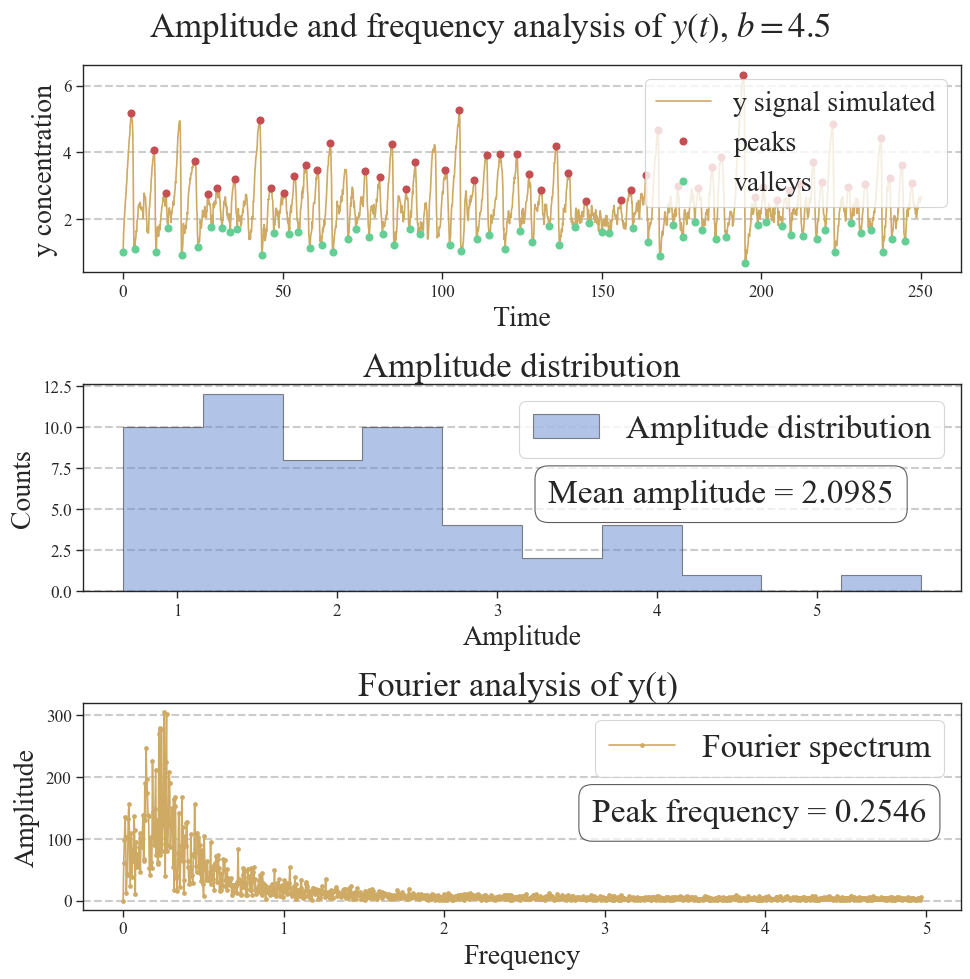

In [156]:
mean_y = np.mean(y_sim)
y_norm = y_sim - mean_y
freq_fourier, amp_fourier, peak_freq_fourier = easy_fourier(t_list, y_norm)

t_peaks, y_peaks = peak_find(t_list, y_sim, neigh=20)
t_valleys, y_valleys= valley_find(t_list, y_sim, neigh=20)

# Match peaks with valleys
amp = amp_match(t_peaks, y_peaks, t_valleys, y_valleys)
mean_amp = np.mean(amp)

props = dict(boxstyle='round', facecolor='white', edgecolor='k',  alpha=0.7, pad=0.4)

fig, ax = plt.subplots(3, 1, figsize=(10, 10), dpi=100)
ax[0].plot(t_list, y_sim, label='y signal simulated', color=colors[1])
ax[0].plot(t_peaks, y_peaks, 'ro', label='peaks')
ax[0].plot(t_valleys, y_valleys, 'go', label='valleys', color=colors[3])
ax[0].set_xlabel('Time', fontsize=20)
ax[0].set_ylabel('y concentration', fontsize=20)
ax[0].legend(fontsize=20)


ax[1].hist(amp, bins=10, alpha=0.5, label='Amplitude distribution', edgecolor='k', histtype='stepfilled', color=colors[5]);
ax[1].text(0.53, 0.43, f'Mean amplitude = {mean_amp:.4f}',transform=ax[1].transAxes, fontsize=24, bbox=props)
ax[1].set_xlabel('Amplitude', fontsize=20)
ax[1].set_ylabel('Counts', fontsize=20)
ax[1].set_title('Amplitude distribution', fontsize=25)
ax[1].legend(fontsize=24)

ax[2].plot(freq_fourier, amp_fourier, marker='.', ls='-', label='Fourier spectrum', color=colors[1])
ax[2].text(0.58, 0.43, f'Peak frequency = {peak_freq_fourier:.4f}', transform=ax[2].transAxes, fontsize=24, bbox=props)
ax[2].set_xlabel('Frequency', fontsize=20)
ax[2].set_ylabel('Amplitude', fontsize=20)
ax[2].set_title('Fourier analysis of y(t) ', fontsize=25)
ax[2].legend(fontsize=24, loc='upper right') 

fig.suptitle(rf'Amplitude and frequency analysis of $y(t)$, $b = {b}$', fontsize=25)
plt.tight_layout()

plt.savefig('figurer/amp_freq_analysis.png', dpi=150)

In [157]:
# Defining Gillespie simulation function

@numba.njit(fastmath=True)
def gil_sim(b, vol, t_max, x, y):
    t_sim, x_sim, y_sim = gillespie(x, y, t_max, b_place=b, V=vol)
    y_norm = y_sim - np.mean(y_sim)
    f_slice, a_slice, peak_f = easy_fourier(t_sim, y_norm)
    t_peak, y_peak = peak_find(t_sim, y_sim, neigh=20)
    t_valley, y_valley = valley_find(t_sim, y_sim, neigh=20)

    amps = amp_match(t_peak, y_peak, t_valley, y_valley)
    mean_amp = np.mean(amps)

    return peak_f, amps, mean_amp
    

In [158]:
### RUN ONLY IF NECESSARY ###

# # Initializing gillespie simulation
# vol = 100
# x = 100
# y = 100
# b_val = np.array([4.5, 5.5])
# t_max = 250
# N = 100
# 
# # Running simulation
# b_amp_mean = []
# freq_list_1vol = []
# 
# for i in b_val:
#     mean_amp_list = []
#     freq_list = []
#     for j in range(N):
#         peak_f, amps, mean_amp = gil_sim(i, vol, t_max, x, y)
#         amps = amps / vol
#         mean_amp = mean_amp / vol  
#         if peak_f == 0:
#             break
#         else:
#             mean_amp_list.append(mean_amp)
#             freq_list.append(peak_f)
#     
#     freq_list_1vol.append(freq_list)
#     b_amp_mean.append(mean_amp_list)
# 
# # Save results as csv files
# np.savetxt('data/brusselator_amp_mean.csv', b_amp_mean, delimiter=',')
# np.savetxt('data/brusselator_freq_list.csv', freq_list_1vol, delimiter=',')


Text(0.5, 0.98, 'Mean amplitude and frequency distribution for N = 100 runs,  $b=[4.5, 5.5]$ for $\\Omega = 100$')

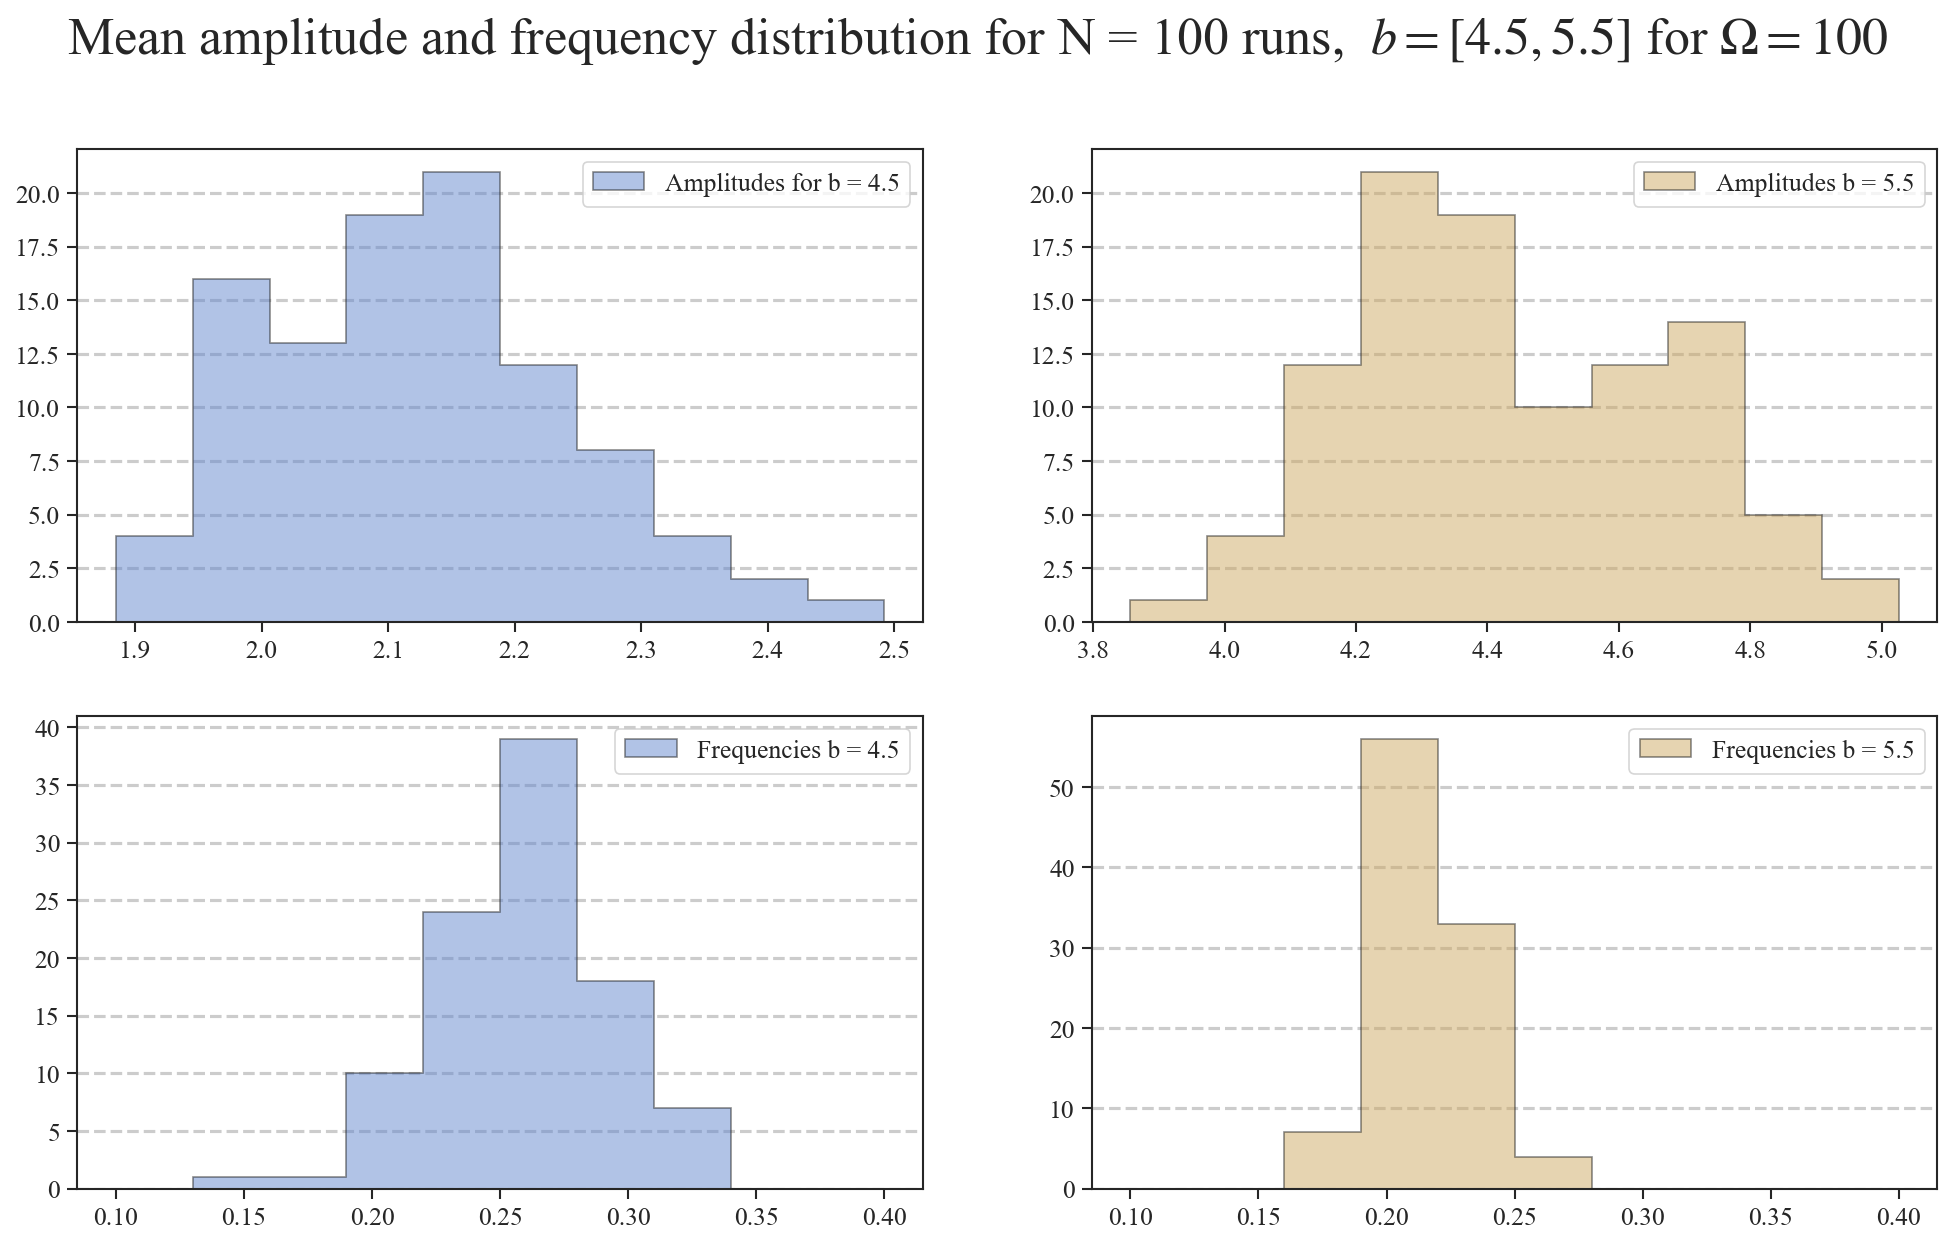

In [159]:
# Load results
b_amp_mean = np.loadtxt('data/brusselator_amp_mean.csv', delimiter=',')
freq_list_1vol = np.loadtxt('data/brusselator_freq_list.csv', delimiter=',')

N = 100

# Results 

#sigma_amp = np.std(mean_amp_list)
#print(f'Standard deviation of mean amplitudes sigma_A = {sigma_amp:.2f}')

b_amp_mean = np.array(b_amp_mean)
mean_freq45 = np.mean(freq_list_1vol[0])
mean_freq55 = np.mean(freq_list_1vol[1])

N_bins = 10

fig, ax = plt.subplots(2, 2)
ax[0,0].hist(b_amp_mean[0], bins=N_bins, alpha=0.5, label='Amplitudes for b = 4.5', edgecolor='k', histtype='stepfilled', color=colors[5])
ax[0,0].legend()
ax[0,1].hist(b_amp_mean[1], bins=N_bins, alpha=0.5, label='Amplitudes b = 5.5', edgecolor='k', histtype='stepfilled', color=colors[1])
ax[0,1].legend()

f_range = [0.1, 0.4 ]
ax[1,0].hist(freq_list_1vol[0], range=f_range, bins=N_bins, alpha=0.5, label='Frequencies b = 4.5', edgecolor='k', histtype='stepfilled', color=colors[5])
ax[1,0].legend()
ax[1,1].hist(freq_list_1vol[1], range=f_range, bins=N_bins, alpha=0.5, label='Frequencies b = 5.5', edgecolor='k', histtype='stepfilled', color=colors[1])
ax[1,1].legend()
fig.suptitle(fr'Mean amplitude and frequency distribution for N = {N} runs,  $b=[4.5, 5.5]$ for $\Omega = 100$', fontsize=25)

# Gillespie simulation for many volumes $\Omega$ and b = [4.5, 5.5]



In [160]:
# RUN ONLY IF NECESSARY ###
#a = 2
#c = 1
#d = 1
#b = [4.5, 5.5]
#
#x = 100
#y = 100
#
#vol = np.linspace(20, 240, 12)
#
#t_max = 250
#N = 100
#
#vol_amp = []
#sigma_list = []
#for i in tqdm(vol):
#    b_amp_list = []
#    b_sigma_list = []
#    for j in b:
#        mean_amp_list = []
#        for _ in range(N):
#            peak_f, amps, mean_amp = gil_sim(j, i, t_max, x, y)
#
#            mean_amp_list.append(mean_amp)
#        b_sigma_list.append(np.std(mean_amp_list/i))
#        b_amp_list.append(mean_amp_list/i)
#    sigma_list.append(b_sigma_list)
#    vol_amp.append(b_amp_list)

In [161]:
#### RUN ONLY IF ABOVE CELL HAS BEEN RUN ###
 
 
# Save results in csv file
#amps = np.array(vol_amp)
#sigmas = np.array(sigma_list)
#
#amps_b45 = amps[:,0]
#amps_b55 = amps[:,1]
#
#sigmas_b45 = sigmas[:,0]
#sigmas_b55 = sigmas[:,1]
#
#
#np.savetxt('data/amps_b45.csv', amps_b45, delimiter=',')
#np.savetxt('data/amps_b55.csv', amps_b55, delimiter=',')
#np.savetxt('data/sigmas_b45.csv', sigmas_b45, delimiter=',')
#np.savetxt('data/sigmas_b55.csv', sigmas_b55, delimiter=',')


In [162]:
# Read results from csv file

vol = np.linspace(20, 240, 12)
b = [4.5, 5.5]

amps_b45 = np.genfromtxt('data/amps_b45.csv', delimiter=',')
amps_b55 = np.genfromtxt('data/amps_b55.csv', delimiter=',')
sigmas_b45 = np.genfromtxt('data/sigmas_b45.csv', delimiter=',')
sigmas_b55 = np.genfromtxt('data/sigmas_b55.csv', delimiter=',')


vol_amp = np.array([amps_b45, amps_b55])
sigma_list = np.array([sigmas_b45, sigmas_b55])


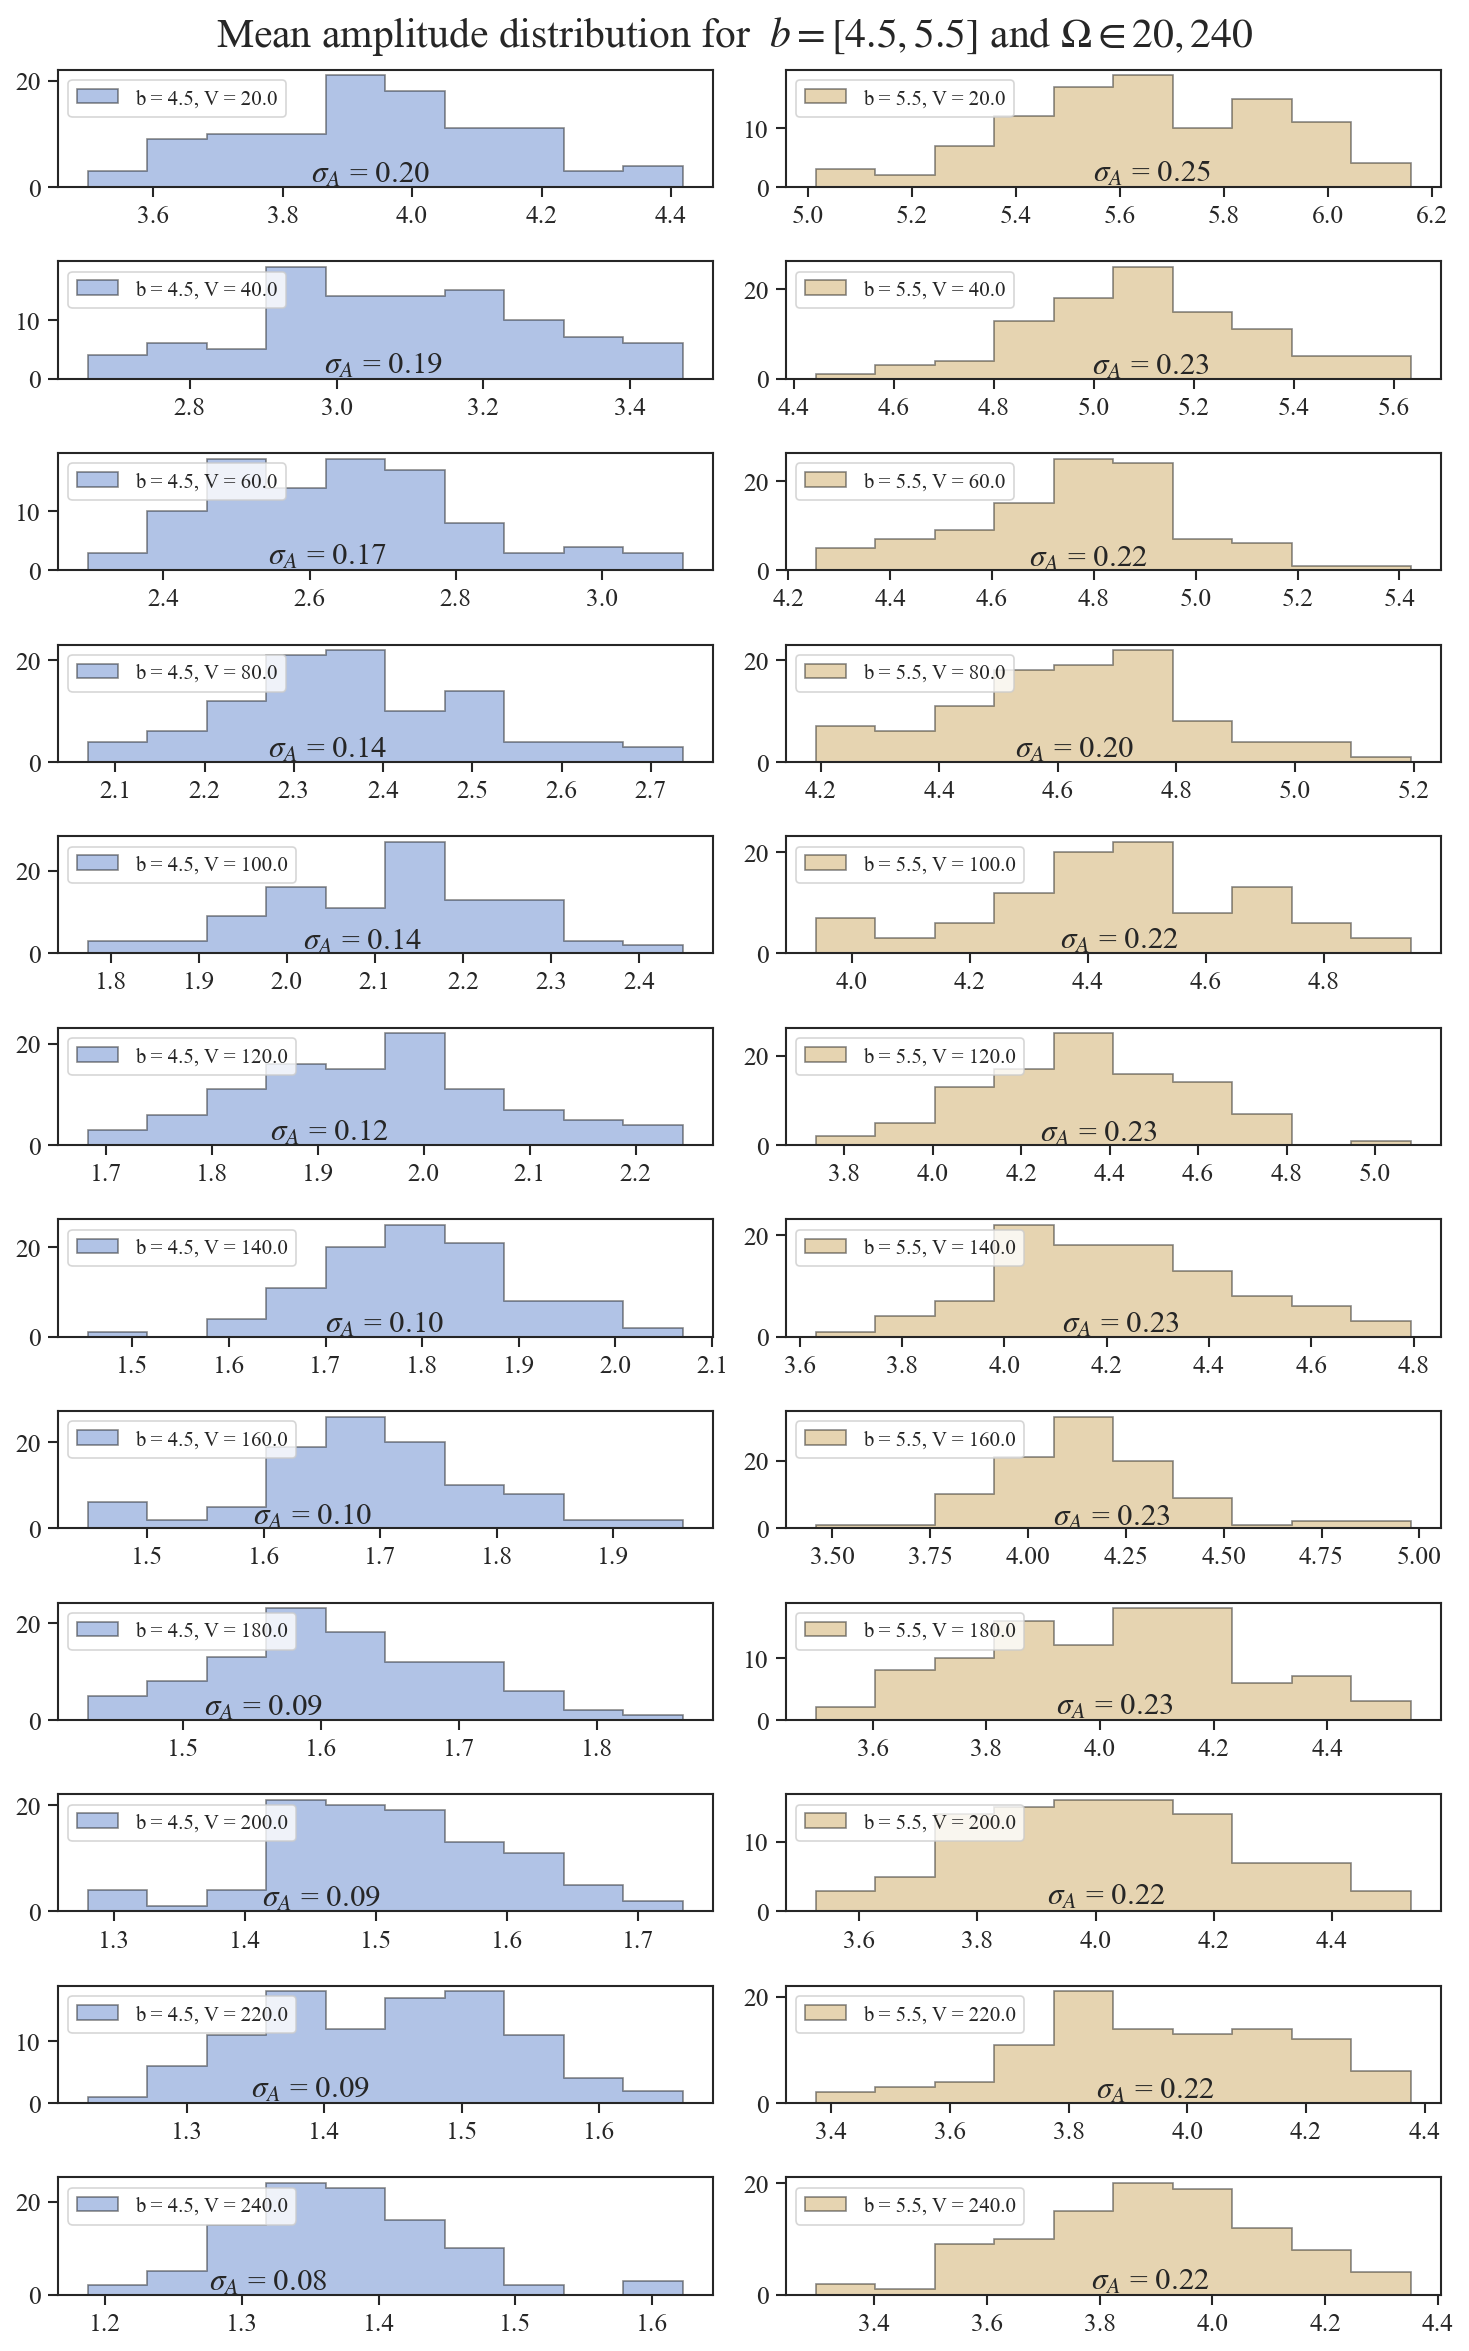

In [163]:
fig, ax = plt.subplots(len(vol), 2, figsize=(10, 16), dpi=150)
N_bins = 10

for i in range(len(vol)):
    for j in range(2):
        mean_dist = np.mean(vol_amp[j][i])
        r_low = mean_dist - 0.5
        r_high = mean_dist + 0.5
        hist_range = [r_low, r_high]
        if j == 0:
            hist_color = colors[5]
        else:
            hist_color = colors[1]

        ax[i, j].hist(vol_amp[j][i], bins=N_bins, alpha=0.5, label=f'b = {b[j]}, V = {vol[i]}', edgecolor='k', histtype='stepfilled', color=hist_color)
        ax[i, j].text(mean_dist - 0.1, 1, f'$\sigma_A$ = {sigma_list[j][i]:.2f}', fontsize=15)
        ax[i, j].legend(fontsize=10, loc='upper left')
        ax[i, j].grid(False)


fig.suptitle(r'Mean amplitude distribution for  $b=[4.5, 5.5]$ and $\Omega \in {20, 240}$', fontsize=20); 
fig.tight_layout()

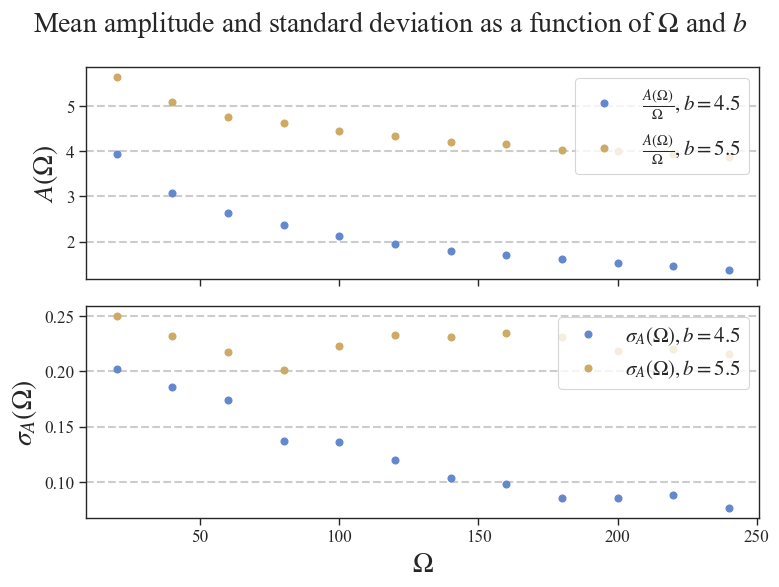

In [164]:
# Plotting the mean amplitude as a function of volume

mean_amp_b45 = []
std_b45 = []

mean_amp_b55 = []
std_b55 = []


for i in range(12):
    mean_amp_b45.append(np.mean(vol_amp[0,i]))
    std_b45.append(np.std(vol_amp[0,i]))

    mean_amp_b55.append(np.mean(vol_amp[1,i]))
    std_b55.append(np.std(vol_amp[1,i]))

fig, ax = plt.subplots(2,1, figsize=(8,6), dpi=100, sharex=True)
ax[0].plot(vol, mean_amp_b45, label=r'$\frac{A(\Omega )}{\Omega}, b = 4.5$', color=colors[5], marker='o', ls='')
ax[0].plot(vol, mean_amp_b55, label=r'$\frac{A(\Omega )}{\Omega}, b = 5.5$', color=colors[1], marker='o', ls='')
ax[0].set_ylabel(r'$A(\Omega)$', fontsize=20)
ax[0].legend(fontsize=15, loc='upper right')

ax[1].plot(vol, std_b45, label=r'$\sigma_A (\Omega), b = 4.5$', color=colors[5], marker='o', ls='')
ax[1].plot(vol, std_b55, label=r'$\sigma_A (\Omega), b = 5.5$', color=colors[1], marker='o', ls='')
ax[1].set_xlabel(r'$\Omega$', fontsize=20)
ax[1].set_ylabel(r'$\sigma_A (\Omega)$', fontsize=20)
ax[1].legend(fontsize=15, loc='upper right')

fig.suptitle(r'Mean amplitude and standard deviation as a function of $\Omega$ and $b$', fontsize=20)
fig.tight_layout()



plt.savefig('figurer/amp_std_vol.png', dpi=150)


_____
_____

# Gillespie simulation for two volumes $\Omega = \Omega_1 + \Omega_2$ 

___

In [165]:
# Defining gillespie algorithm for system with V = v1 + v2

@numba.njit(fastmath=True)
def gill_vnew(x1, y1, x2, y2, v0, t_max, b_place):
    
    t = 0
    click = 1
    t_list = [0]

    x1_list = [x1]
    y1_list = [y1]

    x2_list = [x2]
    y2_list = [y2]

    v1_list = [v0/2]
    v2_list = [v0/2]

    while t < t_max:

        v1 = (x1+y1)/(x1+y1+x2+y2) * (v0)
        v2 = (x2+y2)/(x1+y1+x2+y2) * (v0)

        a1 = 2 * v1
        c1 = 1/ v1**2
        d1 = 1

        a2 = 2 * v2
        c2 = 1/ v2**2
        d2 = 1

        # rates for v1
        x1_s = a1
        x1_to_y1 = b_place * x1
        y1_to_x1 = c1 * x1 * (x1-1) * y1
        x1_ds = d1 * x1

        # rates for v2
        x2_s = a2
        x2_to_y2 = b_place * x2
        y2_to_x2 = c2 * x2 * (x2-1) * y2
        x2_ds = d2 * x2

        rates = np.array([x1_s, x1_to_y1, y1_to_x1, x1_ds, x2_s, x2_to_y2, y2_to_x2, x2_ds])

        r_sum = np.cumsum(rates)
        R = np.sum(rates)
        u = np.random.uniform(0, R)
        dt = -np.log(np.random.uniform())/R

        mask = r_sum > u
        index = np.where(mask == True)[0][0]

        if index == 0:
            x1 += 1

        elif index == 1:
            x1 -= 1
            y1 += 1

        elif index == 2:
            y1 -= 1
            x1 += 1

        elif index == 3:
            x1 -= 1

        elif index == 4:
            x2 += 1

        elif index == 5:
            x2 -= 1
            y2 += 1
        
        elif index == 6:
            y2 -= 1
            x2 += 1

        elif index == 7:
            x2 -= 1

        t += dt
        ts = 0.1
        if t > ts*click:
            t_list.append(t)
            x1_list.append(x1/v0)
            y1_list.append(y1/v0)
            x2_list.append(x2/v0)
            y2_list.append(y2/v0)
            v1_list.append(v1)
            v2_list.append(v2)
            
            click += 1
        
    return np.array(t_list), np.array(x1_list), np.array(y1_list), np.array(x2_list), np.array(y2_list), np.array(v1_list), np.array(v2_list)

    

In [166]:
# Gillespie simulation initialization

# Starting parameters [x, y, v]
start1 = [2, 2]
start2 = [2, 2]
v0 = 100

t_max = 250
b = 4.5

# Running simulation
t_list, x1_sim, y1_sim, x2_sim, y2_sim, v1_list, v2_list = gill_vnew(start1[0], start1[1], start2[0], start2[1], v0,  t_max, b)



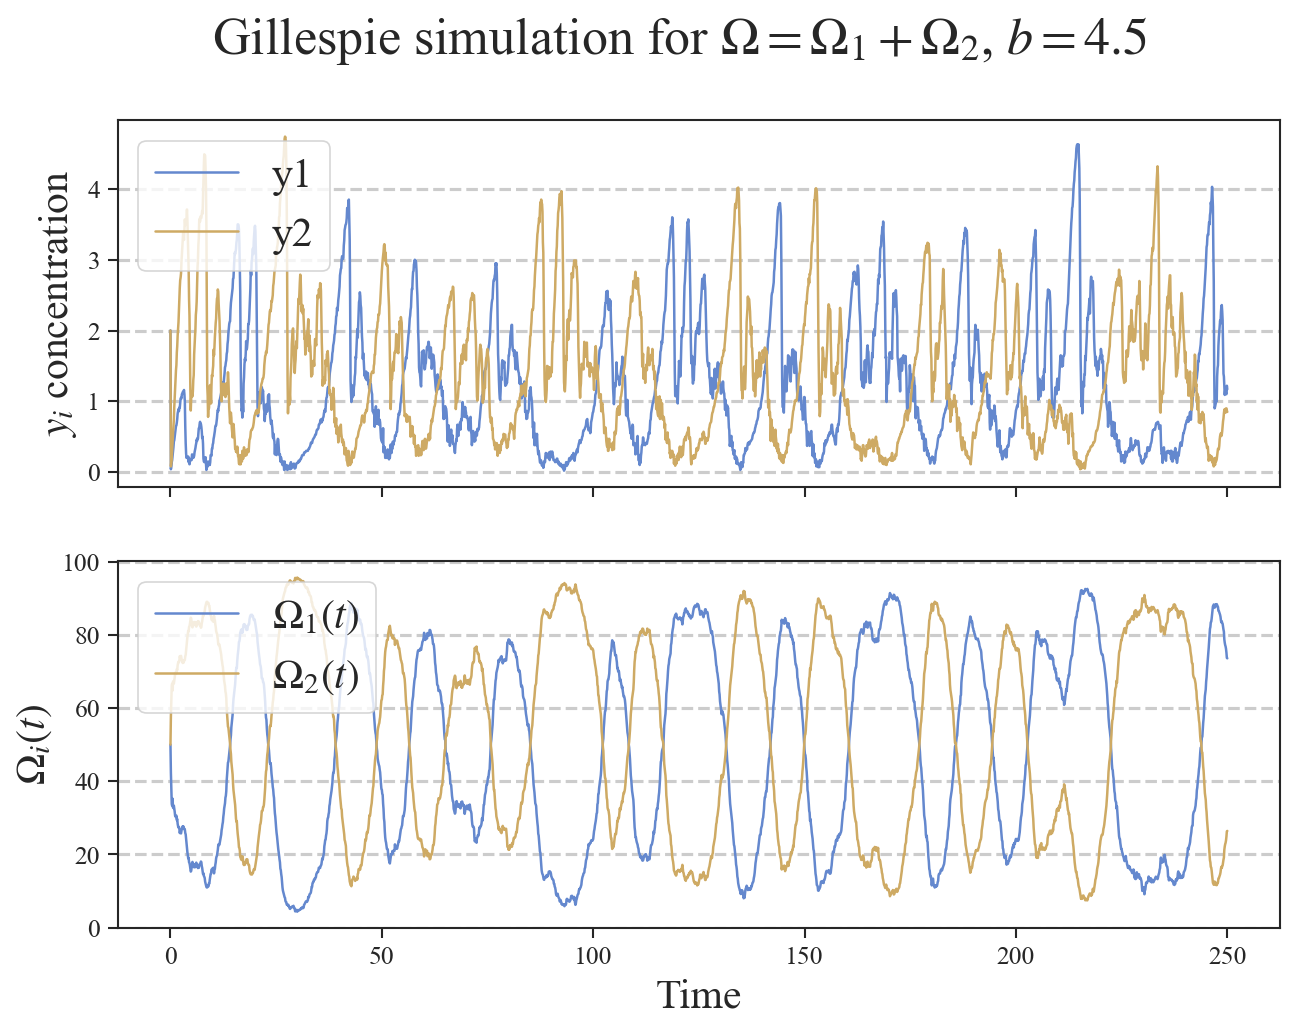

In [167]:
# Plotting results

fig, ax = plt.subplots(2, 1, figsize=(10, 7), sharex=True)
#ax[0].plot(t_list, x1_sim, label='x1', color=colors[0])
#ax[0].plot(t_list, x2_sim, label='x2', color=colors[1])
#ax[0].set_ylabel(r'$x$ concentration', fontsize=20)

ax[0].plot(t_list, y1_sim, label='y1', color=colors[5])
ax[0].plot(t_list, y2_sim, label='y2', color=colors[1])
ax[0].set_ylabel(r'$y_i$ concentration', fontsize=20)

ax[1].plot(t_list, v1_list, label = r'$\Omega_1(t)$', color=colors[5])
ax[1].plot(t_list, v2_list, label = r'$\Omega_2(t)$', color=colors[1])
ax[1].set_xlabel('Time', fontsize=20)
ax[1].set_ylabel(r'$\Omega_i(t)$', fontsize=20)

for i in range(len(ax)):
    ax[i].legend(fontsize=20, loc='upper left')

fig.suptitle(r'Gillespie simulation for $\Omega = \Omega_1 + \Omega_2$, $b = 4.5$', fontsize=25)

plt.savefig('figurer/gillespie_two_vol.png', dpi=150)


Text(0.5, 1.0, 'Fourier anaylsis of $\\Omega_1(t)$')

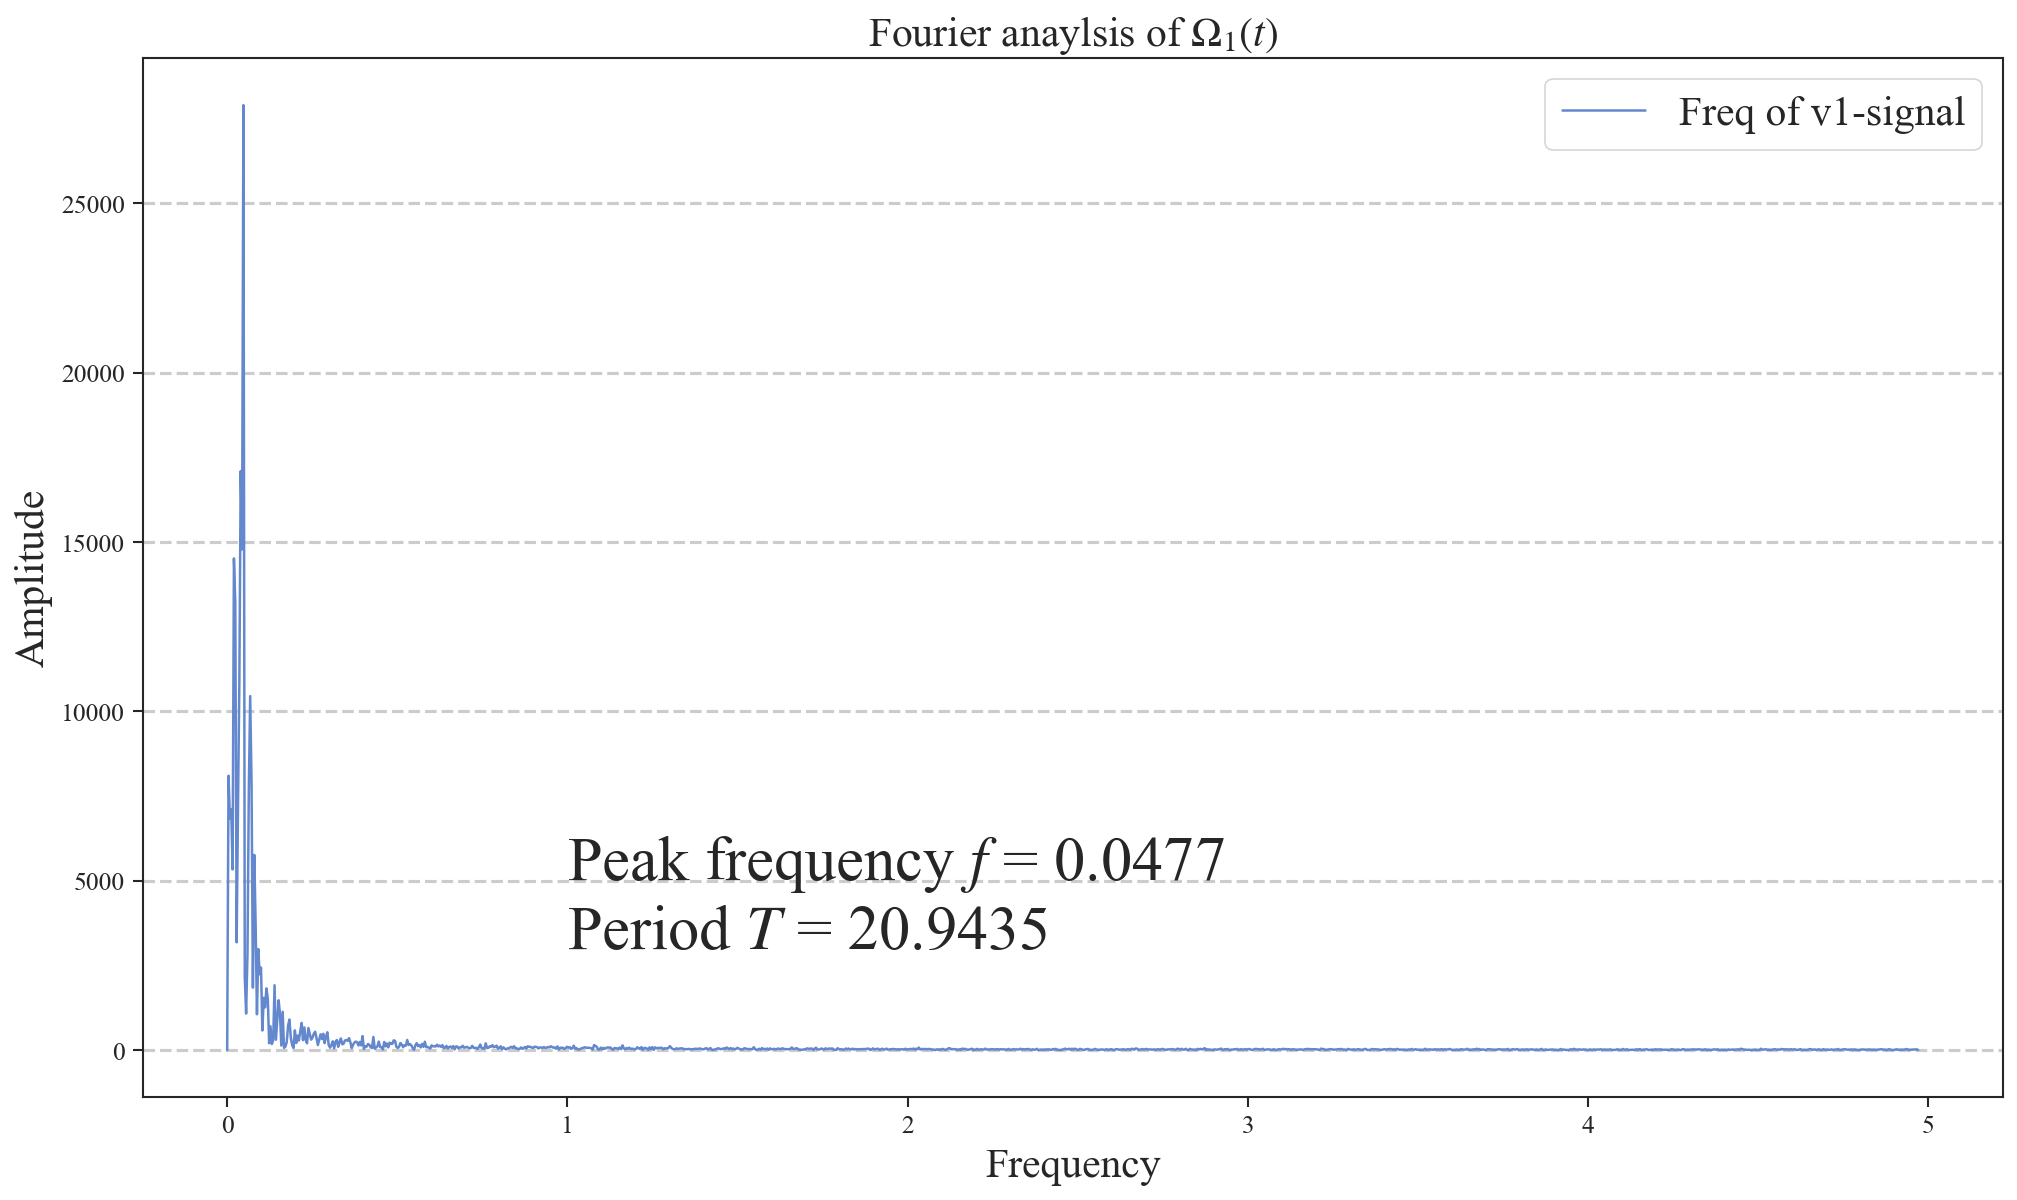

In [168]:
# Finding frequency for the volume signals

mean_freq_v1 = np.mean(v1_list)
v1_list_norm = v1_list - mean_freq_v1

freq_v1, amp_v1, peak_v1 = easy_fourier(t_list, v1_list_norm)
period_v1 = 1/peak_v1


fig, ax = plt.subplots()
ax.plot(freq_v1, amp_v1, label='Freq of v1-signal', color=colors[5])
ax.text(1, 5050, fr'Peak frequency $f$ = {peak_v1:.4f}', fontsize=30)
ax.text(1, 3000, fr'Period $T$ = {period_v1:.4f}', fontsize=30)
ax.set_ylabel('Amplitude', fontsize=20)
ax.set_xlabel('Frequency', fontsize=20)
ax.legend(fontsize=20)
ax.set_title(r'Fourier anaylsis of $\Omega_1(t)$', fontsize=20)

In [169]:
# Simulate 1000 systems with same parameters

@numba.njit(fastmath=True)
def two_vol_gil(x1, y1, x2, y2, v0, t_max, b_place, N):

    two_vol_freq_list = []
    two_vol_T_list = []

    for i in range(N):
        t_list, x1_sim, y1_sim, x2_sim, y2_sim, v1_list, v2_list = gill_vnew(x1, y1, x2, y2, v0, t_max, b_place)
        t_peaks_v1, peaks_v1 = peak_find(t_list, v1_list, neigh = 100)

        T_list = np.diff(t_peaks_v1)
        
        mean_freq_v1 = np.mean(v1_list)
        v1_list_norm = v1_list - mean_freq_v1

        freq_v1, amp_v1, peak_v1 = easy_fourier(t_list, v1_list_norm)
        two_vol_freq_list.append(peak_v1)
        two_vol_T_list.append(T_list)

    return two_vol_freq_list


In [175]:
# Running simulation

N = 1000
start1 = [2, 2]
start2 = [2, 2]
v0 = 100
t_max = 250
b = 4.5


### RUN ONLY IF NECESSARY ###

# two_vol_freq_list = two_vol_gil(start1[0], start1[1], start2[0], start2[1], v0, t_max, b, N)
# 
# # Save results in csv file
# np.savetxt('data/sim_two_vol.csv', two_vol_freq_list, delimiter=',')

In [176]:
# Read results from csv file
two_vol_freq_list = np.genfromtxt('data/sim_two_vol.csv', delimiter=',')

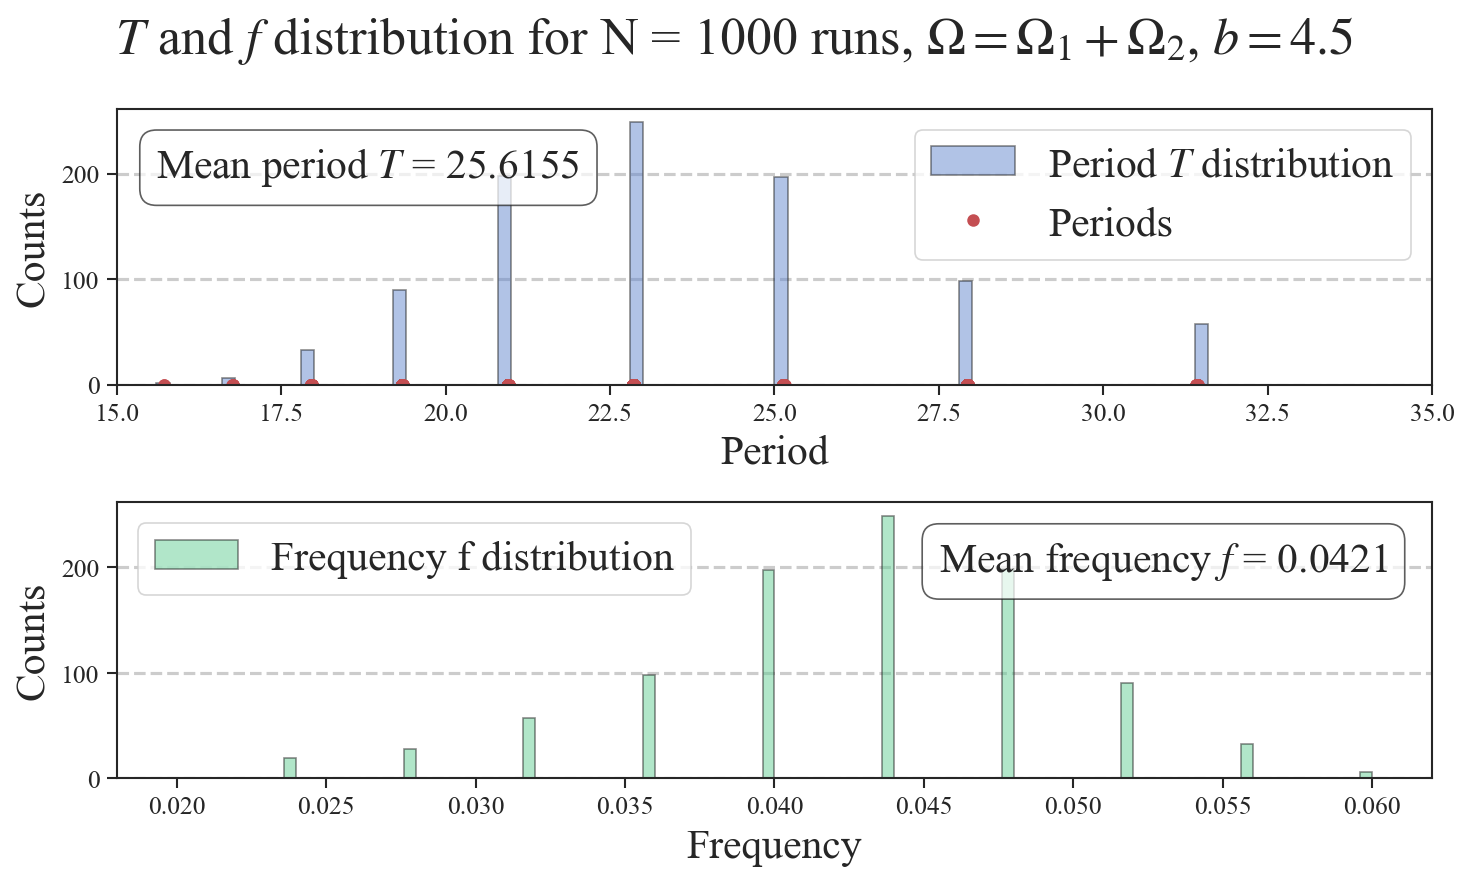

In [177]:
fig, ax = plt.subplots(2,1, figsize=(10, 6))

period_list = 1/np.array(two_vol_freq_list)
mean_period = np.mean(period_list)
hist_range_p = [15, 35]

zero_list = np.zeros(N)
props = dict(boxstyle='round', facecolor='white', edgecolor='k',  alpha=0.7, pad=0.4)

ax[0].hist(period_list, range=hist_range_p, bins=100, alpha=0.5, histtype='stepfilled', color=colors[5] ,edgecolor='k', label=r'Period $T$ distribution');
ax[0].plot(period_list, zero_list, 'ro', markersize=5, label = 'Periods')
ax[0].set(xlim=hist_range_p)
ax[0].set_xlabel('Period', fontsize=20)
ax[0].set_ylabel('Counts', fontsize=20)
ax[0].text(0.03, 0.75, fr'Mean period $T$ = {mean_period:.4f}', transform=ax[0].transAxes, bbox=props, fontsize=20)
ax[0].legend(fontsize=20, loc='upper right')

mean_freq = np.mean(two_vol_freq_list)
hist_range_f = [0.02, 0.06]
ax[1].hist(two_vol_freq_list, bins=100, alpha=0.5, range=hist_range_f, histtype='stepfilled', color= colors[3], edgecolor='k', label='Frequency f distribution');
ax[1].text(0.625, 0.75, fr'Mean frequency $f$ = {mean_freq:.4f}', bbox=props, transform=ax[1].transAxes, fontsize=20)
ax[1].set_xlabel('Frequency', fontsize=20)
ax[1].set_ylabel('Counts', fontsize=20)
ax[1].legend(fontsize=20, loc='upper left')

fig.suptitle(fr'$T$ and $f$ distribution for N = {N} runs, $\Omega = \Omega_1 + \Omega_2$, $b = 4.5$', fontsize=25)
fig.tight_layout()

plt.savefig('figurer/period_freq_dist.png', dpi=150)

In [173]:
# Find  binmids of frequency distribution

hist, bin_edges = np.histogram(period_list, bins=100, range=hist_range_p)
bin_mids = 0.5 * (bin_edges[1:] + bin_edges[:-1])

# find bins with counts
mask = hist > 0
bin_mids = bin_mids[mask]

print(bin_mids)

diff = np.diff(bin_mids)
diff = diff

print(diff)

magic_number = 0.2
diff_norm = diff / magic_number
print(diff_norm)

mean_T45 = 1/mean_freq45
determ_T = 3.3

# Comparison to freguency of single volume system b=4.5
relation_sim = mean_T45 / magic_number
relation_determ = determ_T / magic_number

print(relation_sim, relation_determ)


[15.7 16.7 17.9 19.3 20.9 22.9 25.1 27.9 31.5]
[1.  1.2 1.4 1.6 2.  2.2 2.8 3.6]
[ 5.  6.  7.  8. 10. 11. 14. 18.]
19.309627077682805 16.499999999999996


In [174]:
# # Mathias forslag
# 
# N = 1
# start1 = [100, 100]
# start2 = [100, 100]
# v0 = 100
# t_max = 10000
# b = 4.5
# 
# two_vol_freq_list, two_vol_T_list, t_peaks, v1_peaks, t_sim, v1_sim = two_vol_gil(start1[0], start1[1], start2[0], start2[1], v0, t_max, b, N)
# 
# 
# fig, ax = plt.subplots(2,1, figsize=(10, 6))
# hist_range = [10, 35]
# ax[0].hist(two_vol_T_list[0], bins=50, range=hist_range, alpha=0.5, histtype='stepfilled', color=colors[5], edgecolor='k', label='Period $T$ distribution');
# ax[0].set_xlabel('Period', fontsize=20)
# ax[0].set_ylabel('Counts', fontsize=20)
# 
# ax[1].plot(t_peaks, v1_peaks, label='Volume signal', color=colors[5], marker='o', ls='')
# ax[1].plot(t_sim, v1_sim, label='Volume signal simulated', color=colors[1])
# print(len(t_peaks))